In [1]:
# Set the train data folder name
train_number = '00'

# If the start=0, end=500, and gap=5, the sequences will be 00000, 00005, 00010, ..., 00500 (total of 100)
start = 0 
end = 500
gap = 5
num_frames = (end - start)//20

In [1]:
from PIL import Image
import os
import numpy as np
from collections import Counter

# Intrinsic Matrix
K = [[1.000000000000000, 0.0, 0.0, 0.0], [0.0, 1.000000000000000, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]]
    
# Function to get list of ALL extrinsic matrices up to num_frames
def get_all_Rt(cam0_to_world_path, num_frames):
    all_Rt = []
    
    with open(cam0_to_world_path) as f:
        for line in f:
            if len(all_Rt) == 0:
                matrix_split = line.split()
                last_frame_with_info = int(matrix_split[0])
                Rt = [[float(matrix_split[1]), float(matrix_split[2]), float(matrix_split[3]), float(matrix_split[4])],
                      [float(matrix_split[5]), float(matrix_split[6]), float(matrix_split[7]), float(matrix_split[8])],
                      [float(matrix_split[9]), float(matrix_split[10]), float(matrix_split[11]), float(matrix_split[12])],
                      [float(matrix_split[13]), float(matrix_split[14]), float(matrix_split[15]), float(matrix_split[16])]]
                all_Rt.append(Rt)
                continue
                
            next_matrix_split = line.split()
            next_frame_with_info = int(next_matrix_split[0])
            
            for frames in range(next_frame_with_info - last_frame_with_info):
                if len(all_Rt) < num_frames:
                    Rt = [[float(matrix_split[1]), float(matrix_split[2]), float(matrix_split[3]), float(matrix_split[4])],
                          [float(matrix_split[5]), float(matrix_split[6]), float(matrix_split[7]), float(matrix_split[8])],
                          [float(matrix_split[9]), float(matrix_split[10]), float(matrix_split[11]), float(matrix_split[12])],
                          [float(matrix_split[13]), float(matrix_split[14]), float(matrix_split[15]), float(matrix_split[16])]]
                    all_Rt.append(Rt)
                else:
                    f.close()
                    return all_Rt       
                
            last_frame_with_info = next_frame_with_info
            matrix_split = next_matrix_split                                                                                                

In [3]:
# Set relevant paths
directory = '/home/hpaat/courses/comp6411b/ml-gsn/'
cam0_to_world_path = directory + "data/kitti-360/data_poses_2/2013_05_28_drive_0000_sync/cam0_to_world.txt"

# Get list of all Rt (extrinsic matrices)
all_Rt = get_all_Rt(cam0_to_world_path, end)

cameras_json = []
for frame in range(start, end, gap):
    dic = {'K': K, 'Rt': all_Rt[frame]}
    cameras_json.append(dic)

In [4]:
import shutil
import os

# Creating folder of sequence of rgb images and depth data
rgb_path = directory + 'data/kitti-360/KITTI-360/data_2d_raw/2013_05_28_drive_0000_sync/image_00/data_rect/'
new_path = directory + 'data/kitti-360/kitti360_for_mlgsn/train/' + train_number + '/'

if not os.path.exists(new_path):
    os.makedirs(new_path)

for frame in range(start, end, gap):
    src_path = rgb_path + str(frame).zfill(10) + '.png'
    im = Image.open(src_path)
    im = im.crop((516, 0, 892, 376))
    #resizedImage = im.resize((int(376), int(376)), Image.ANTIALIAS)
    dst_path = new_path + str((frame-start)//gap).zfill(3) + '_rgb.png'
    im.save(dst_path, format="png", quality=90)
    #shutil.copy(src_path, dst_path)

In [5]:
# Save the camera file in json format
import json

with open(new_path + 'cameras.json', 'w') as f:
    json.dump(cameras_json, f)

## Projecting Velodyne Points to Depth Map

In [6]:
def load_velodyne_points(filename):
    """Load 3D point cloud from KITTI file format
    (adapted from https://github.com/hunse/kitti)
    """
    points = np.fromfile(filename, dtype=np.float32).reshape(-1, 4)
    points[:, 3] = 1.0  # homogeneous
    return points


def read_calib_file(path):
    """Read KITTI calibration file
    (from https://github.com/hunse/kitti)
    """
    float_chars = set("0123456789.e+- ")
    data = {}
    with open(path, 'r') as f:
        for line in f.readlines():
            key, value = line.split(':', 1)
            value = value.strip()
            data[key] = value
            if float_chars.issuperset(value):
                # try to cast to float array
                try:
                    data[key] = np.array(list(map(float, value.split(' '))))
                except ValueError:
                    # casting error: data[key] already eq. value, so pass
                    pass

    return data


def sub2ind(matrixSize, rowSub, colSub):
    """Convert row, col matrix subscripts to linear indices
    """
    m, n = matrixSize
    return rowSub * (n-1) + colSub - 1

In [7]:
def inverse_rigid_trans(Tr):
    ''' Inverse a rigid body transform matrix (3x4 as [R|t])
        [R'|-R't; 0|1]
    '''
    inv_Tr = np.zeros_like(Tr) # 3x4
    inv_Tr[0:3,0:3] = np.transpose(Tr[0:3,0:3])
    inv_Tr[0:3,3] = np.dot(-np.transpose(Tr[0:3,0:3]), Tr[0:3,3])
    return inv_Tr

In [8]:
import numpy as np

def generate_depth_map(calib_dir, velo_filename, cam=0, vel_depth=False):
    """Generate a depth map from velodyne data
    """
    # load calibration files    
    cam2cam = read_calib_file(os.path.join(calib_dir, 'perspective.txt'))

    path = os.path.join(calib_dir, 'calib_cam_to_velo.txt')
    with open(path, 'r') as f:
        for line in f.readlines():
            cam2velo_list = line.split()

    cam2velo = np.array(cam2velo_list, dtype='float32').reshape(3, 4)
    cam2velo = np.vstack((cam2velo, np.array([0, 0, 0, 1.0])))

    velo2cam = inverse_rigid_trans(cam2velo)

    # get image shape
    im_shape = cam2cam["S_rect_00"][::-1].astype(np.int32)

    # compute projection matrix velodyne->image plane
    R_cam2rect = np.eye(4)
    R_cam2rect[:3, :3] = cam2cam['R_rect_00'].reshape(3, 3)
    P_rect = cam2cam['P_rect_0'+str(cam)].reshape(3, 4)
    P_velo2im = np.dot(np.dot(P_rect, R_cam2rect), velo2cam)

    # load velodyne points and remove all behind image plane (approximation)
    # each row of the velodyne data is forward, left, up, reflectance
    velo = load_velodyne_points(velo_filename)
    velo = velo[velo[:, 0] >= 0, :]

    # project the points to the camera
    velo_pts_im = np.dot(P_velo2im, velo.T).T
    velo_pts_im[:, :2] = velo_pts_im[:, :2] / velo_pts_im[:, 2][..., np.newaxis]

    if vel_depth:
        velo_pts_im[:, 2] = velo[:, 0]

    # check if in bounds
    # use minus 1 to get the exact same value as KITTI matlab code
    velo_pts_im[:, 0] = np.round(velo_pts_im[:, 0]) - 1
    velo_pts_im[:, 1] = np.round(velo_pts_im[:, 1]) - 1
    val_inds = (velo_pts_im[:, 0] >= 0) & (velo_pts_im[:, 1] >= 0)
    val_inds = val_inds & (velo_pts_im[:, 0] < im_shape[1]) & (velo_pts_im[:, 1] < im_shape[0])
    velo_pts_im = velo_pts_im[val_inds, :]

    # project to image
    depth = np.zeros((im_shape[:2]))
    depth[velo_pts_im[:, 1].astype(np.int), velo_pts_im[:, 0].astype(np.int)] = velo_pts_im[:, 2]

    # find the duplicate points and choose the closest depth
    inds = sub2ind(depth.shape, velo_pts_im[:, 1], velo_pts_im[:, 0])
    dupe_inds = [item for item, count in Counter(inds).items() if count > 1]
    for dd in dupe_inds:
        pts = np.where(inds == dd)[0]
        x_loc = int(velo_pts_im[pts[0], 0])
        y_loc = int(velo_pts_im[pts[0], 1])
        depth[y_loc, x_loc] = velo_pts_im[pts, 2].min()
    depth[depth < 0] = 0

    naive_mean_depth_img = np.zeros(depth.shape)
    naive_mean_depth_img = naive_mean_depth_img + np.mean(depth)
    
    return naive_mean_depth_img

In [9]:
from matplotlib import pyplot as plt
def visualize(data):
    plt.imshow(data, interpolation='nearest')
    plt.show()

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


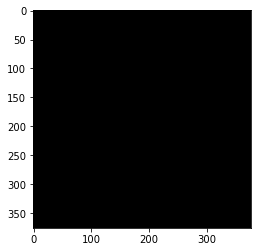

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


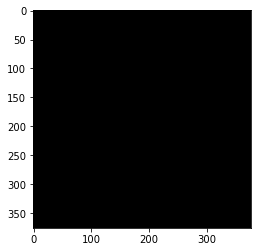

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


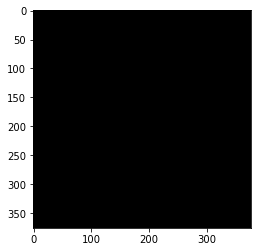

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


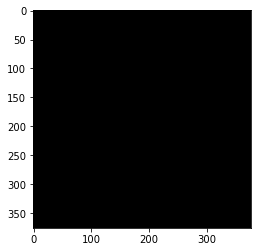

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


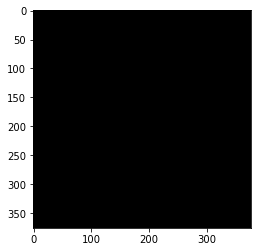

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


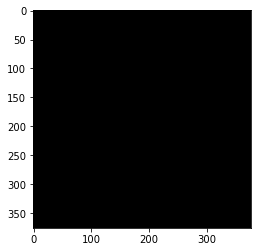

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


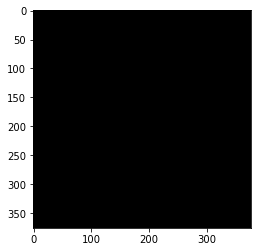

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


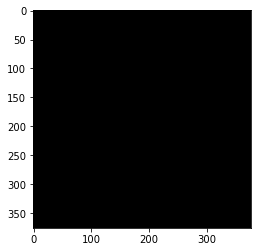

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


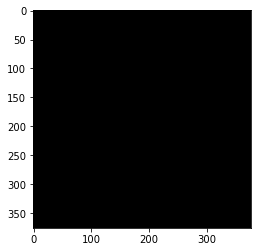

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


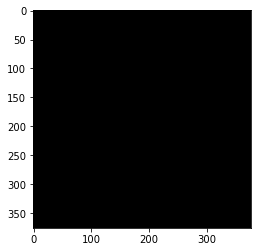

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


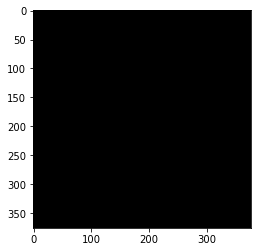

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


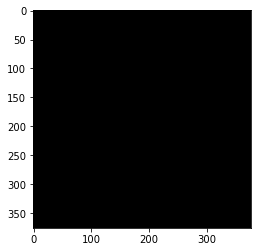

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


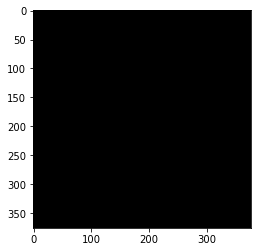

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


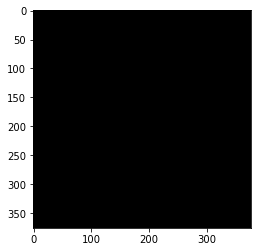

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


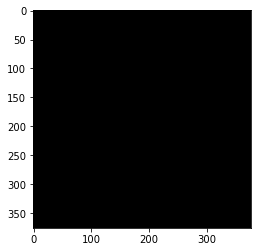

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


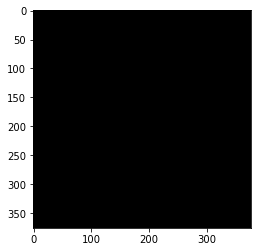

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


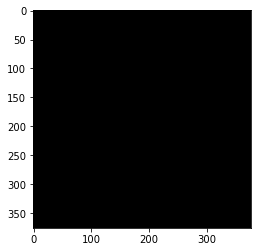

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


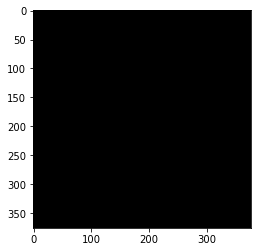

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


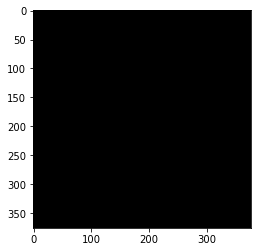

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


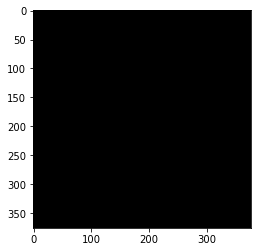

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


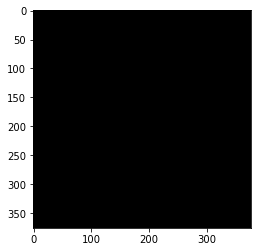

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


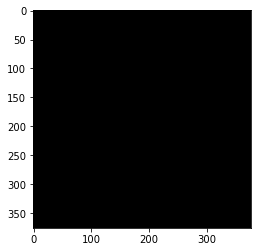

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


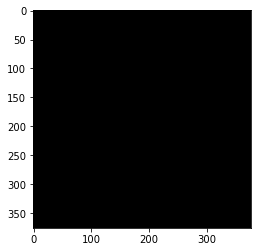

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


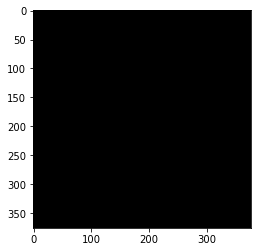

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


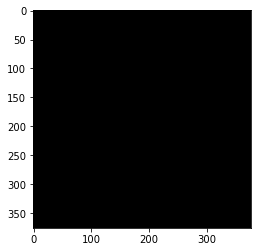

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


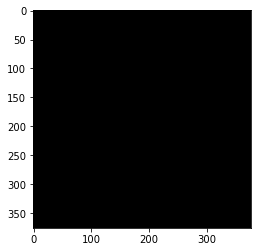

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


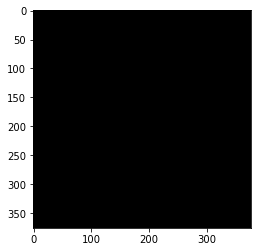

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


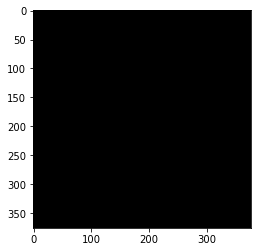

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


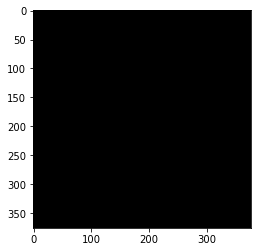

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


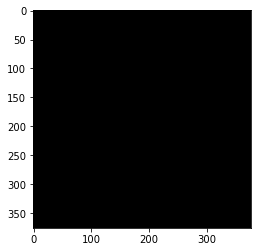

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


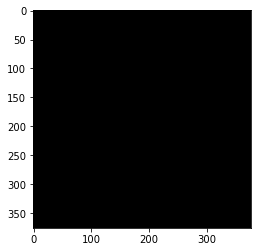

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


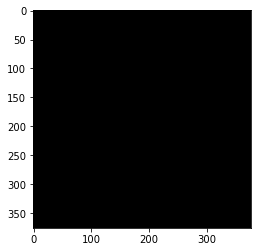

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


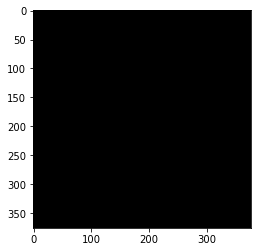

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


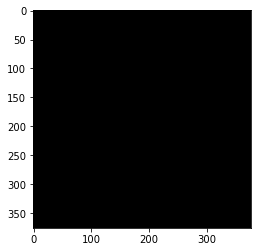

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


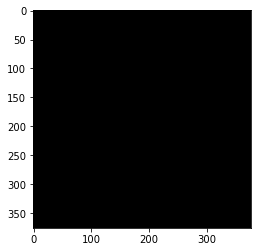

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


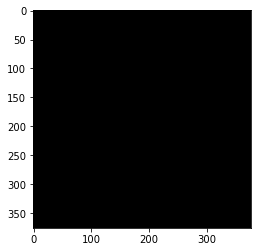

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


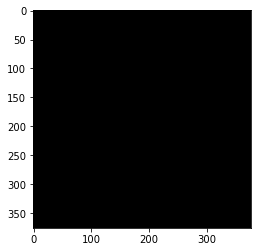

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


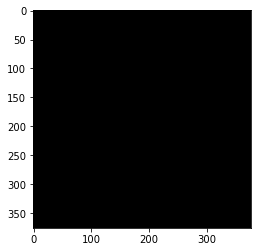

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


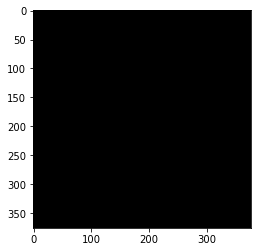

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


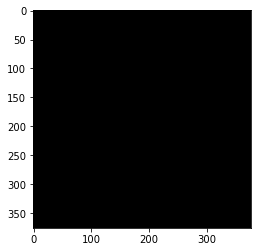

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


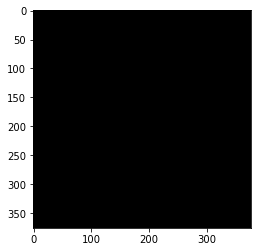

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


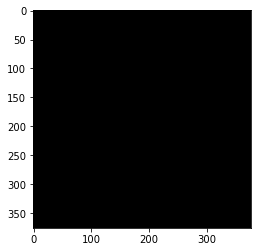

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


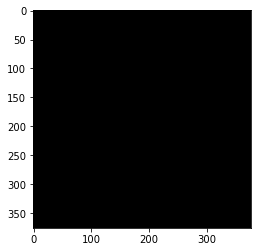

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


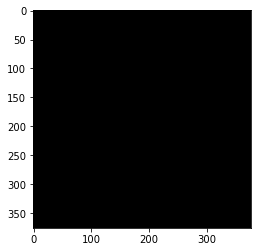

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


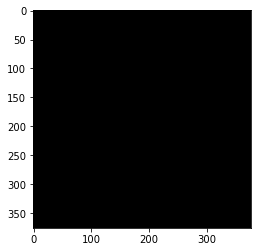

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


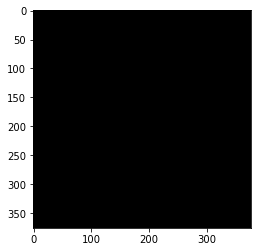

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


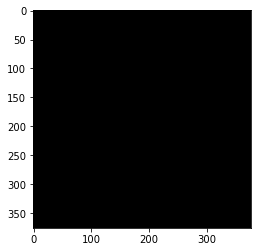

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


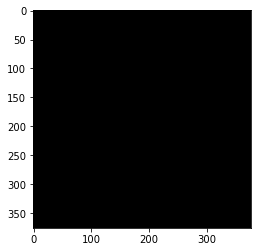

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


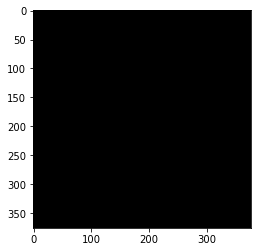

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


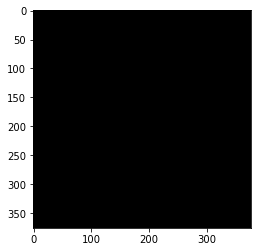

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


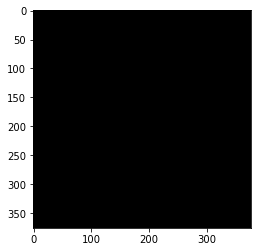

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


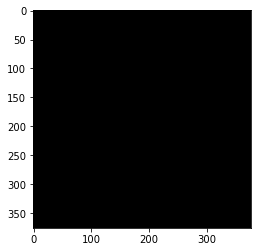

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


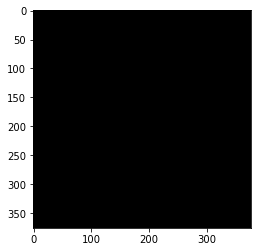

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


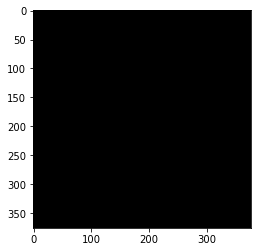

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


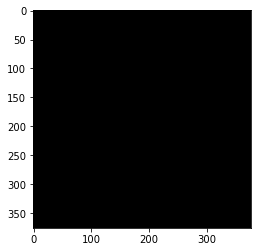

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


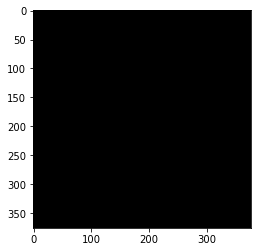

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


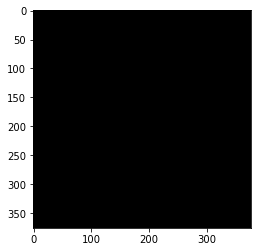

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


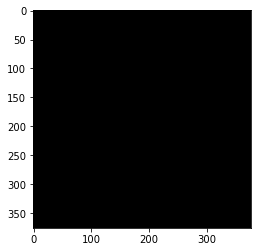

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


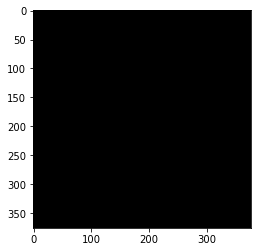

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


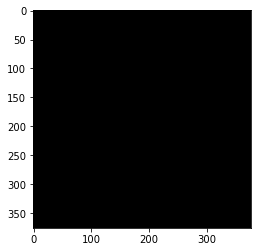

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


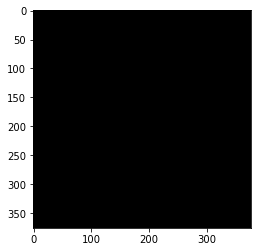

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


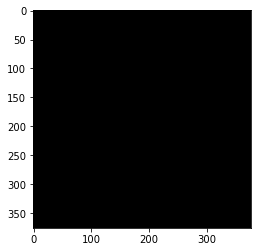

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


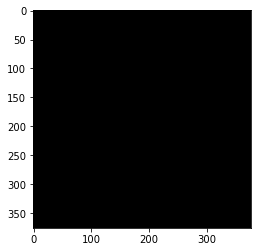

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


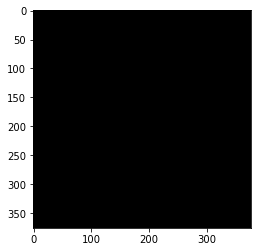

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


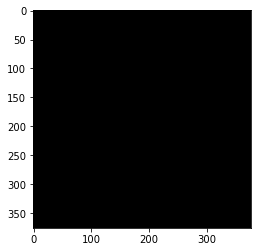

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


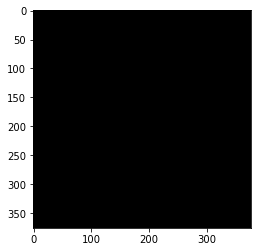

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


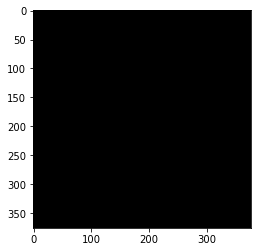

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


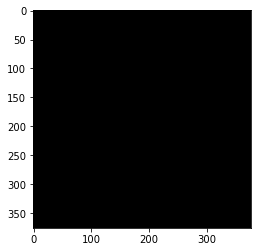

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


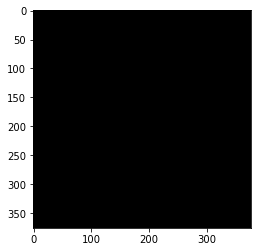

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


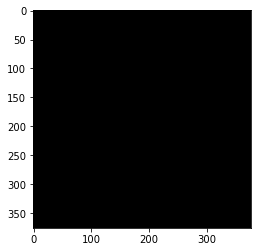

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


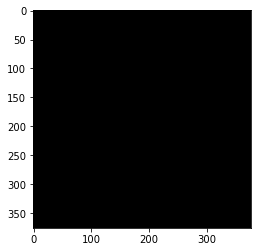

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


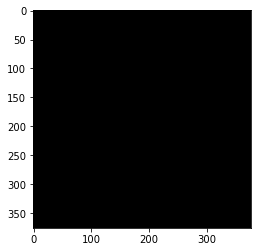

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


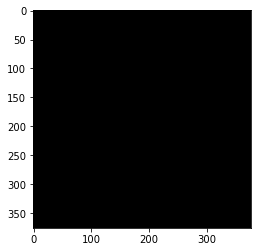

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


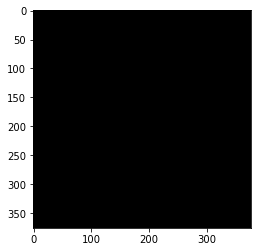

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


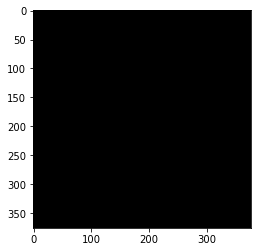

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


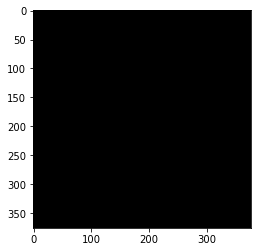

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


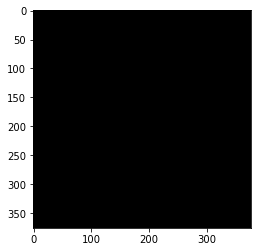

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


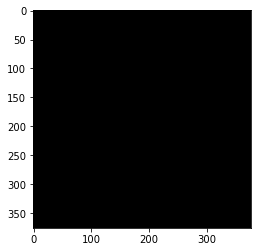

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


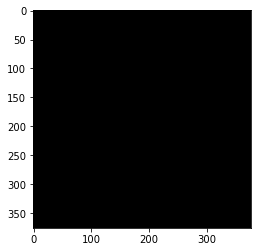

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


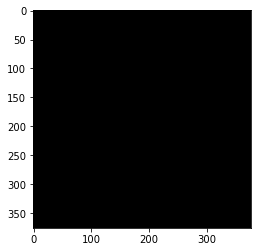

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


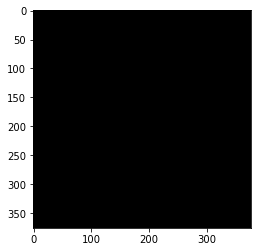

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


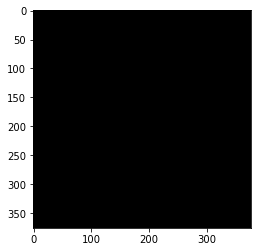

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


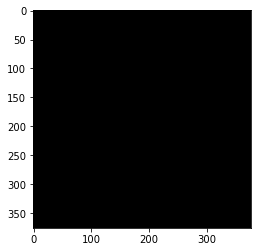

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


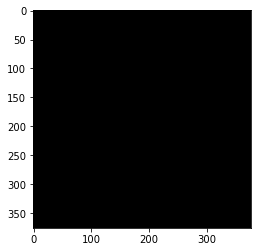

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


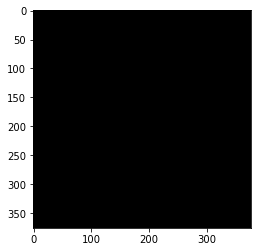

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


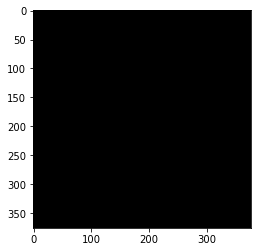

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


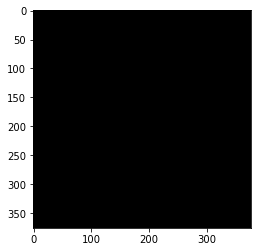

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


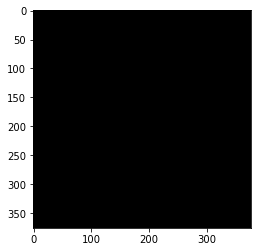

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


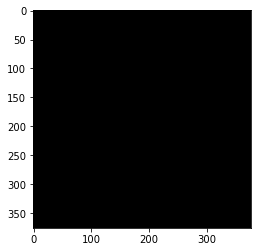

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


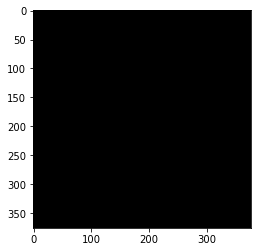

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


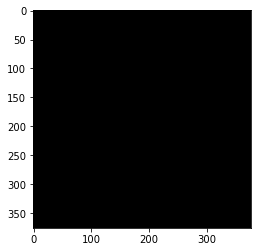

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


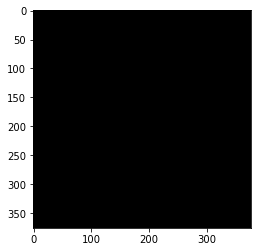

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


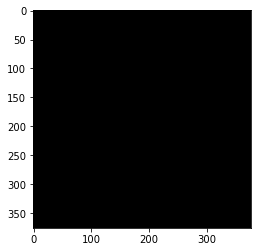

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


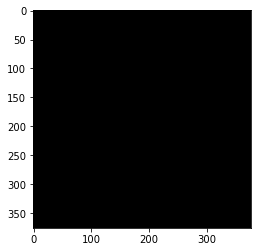

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


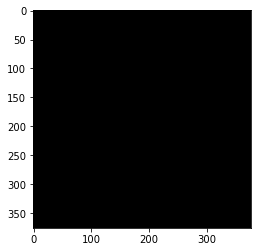

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


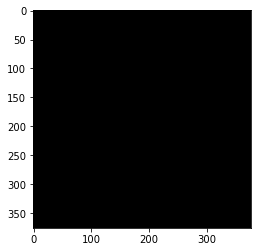

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


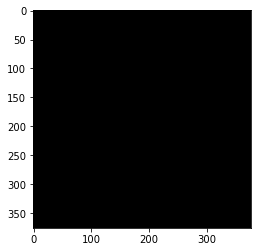

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


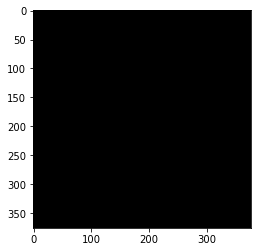

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


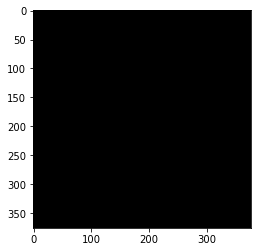

[[0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 ...
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]
 [0.00265957 0.00265957 0.00265957 ... 0.00265957 0.00265957 0.00265957]]
[1. 1. 1. ... 1. 1. 1.]


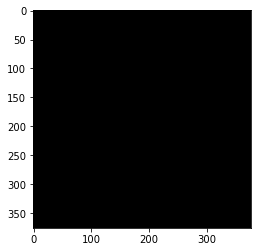

In [10]:
calib_dir = directory + "data/kitti-360/calibration/"
velo_dir = directory + 'data/kitti-360/KITTI-360/data_3d_raw/2013_05_28_drive_0000_sync/velodyne_points/data/'
cam = 0
vel_depth = False

for frame in range(start, end, gap):
    velo_filename = velo_dir + str(frame).zfill(10) + '.bin'  
    depth_map = generate_depth_map(calib_dir, velo_filename)
    depth_map = depth_map/np.sum(depth_map, axis=0)
    print(depth_map)
    print(np.sum(depth_map, axis=0))
    im = Image.fromarray(depth_map, mode='F') 
    #im = im.resize((int(376), int(376)), Image.ANTIALIAS)
    im = im.crop((516, 0, 892, 376))
    visualize(im)
    im.save(new_path + str((frame-start)//gap).zfill(3) + "_depth.tiff", "TIFF")

## Others

In [9]:
im = Image.open('/home/hpaat/courses/comp6411b/ml-gsn/data/replica_all_true/train/00/001_depth.tiff')
im = np.array(im)
print(im)
print('Sum of every row:')
print(np.sum(im, axis=0)[:10])

[[0.0013191  0.00131812 0.00131709 ... 0.00091155 0.00090606 0.00090063]
 [0.00132544 0.00132445 0.00132344 ... 0.00091076 0.00090528 0.00089986]
 [0.00133186 0.00133086 0.00132988 ... 0.00090998 0.0009045  0.00089905]
 ...
 [0.00143419 0.0014349  0.00143562 ... 0.00061553 0.00061304 0.00061056]
 [0.00142937 0.00143009 0.00143078 ... 0.00061513 0.00061264 0.00061016]
 [0.00142458 0.00142527 0.00142597 ... 0.00061474 0.00061223 0.00060977]]
Sum of every row:
[0.8497029  0.8490125  0.84832096 0.84763056 0.846936   0.8462406
 0.84554476 0.8448555  0.84417224 0.84349203]


In [15]:
'''import os

dir_name = "/home/hpaat/courses/comp6411b/ml-gsn/data/replica_all/train/00"
test = os.listdir(dir_name)

for item in test:
    if item.endswith(".tiff"):
        os.remove(os.path.join(dir_name, item))'''

In [16]:
'''import glob, os, shutil

source_dir = '/home/hpaat/courses/comp6411b/ml-gsn/data/replica_all_true/train/00/'
files = glob.iglob(os.path.join(source_dir, "*.tiff"))
for file in files:
    if os.path.isfile(file):
        shutil.copy2(file, dir_name)'''

In [14]:
'''from PIL import Image
im = Image.open('/home/hpaat/courses/comp6411b/ml-gsn/data/replica_all/train/00/000_depth.tiff')
im.show()

import numpy
imarray = numpy.array(im)
print(np.sum(imarray, axis=1))'''

"from PIL import Image\nim = Image.open('/home/hpaat/courses/comp6411b/ml-gsn/data/replica_all/train/00/000_depth.tiff')\nim.show()\n\nimport numpy\nimarray = numpy.array(im)\nprint(np.sum(imarray, axis=1))"